<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/PINNs/blob/main/PINN_Multicomponente_%C3%81gua_e_MEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
#Dominio
x_min, x_max = 0.0, 10.0
y_min, y_max = 0.0, 0.12
t_min, t_max = 0.0, 20.0
v_oil_inlet = 2.21  #escoamento de água
v_meg_inj = 5e-3 #injeção de meg
inj_x, inj_y = 2.0, 0.0 #pontos de injeção
mu_oil = 0.1 #viscosidade o´leo e meg
mu_meg = 0.001
rho_oil = 900 #densidade óleo e meg
rho_meg = 1100

In [2]:
class PINN(nn.Module):
  def __init__(self, camadas_ocultas=6, nos_ocultos=48):
    super().__init__()
    #Aqui é uma rede para Navier Stokes, como disse o professor Jonathan, é preferível separar as redes
    self.uvp_net = nn.Sequential(nn.Linear(3, nos_ocultos), nn.Tanh(), #entrada
          *[nn.Linear(nos_ocultos, nos_ocultos), nn.Tanh()] * (camadas_ocultas), #intermediaria
          nn.Linear(nos_ocultos, 3)) #saída

    #Aqui para transporte de espécies
    self.phase_net = nn.Sequential(nn.Linear(3, nos_ocultos),nn.Tanh(),
          *[nn.Linear(nos_ocultos, nos_ocultos), nn.Tanh()] * (camadas_ocultas),
          nn.Linear(nos_ocultos, 1), nn.Sigmoid()) #a sigmoide é para forçar o valor entre 0 e 1, sendo 0 água e 1 o meg

  def forward(self, x, y, t):
    uvp = self.uvp_net(torch.cat([x, y, t], dim=1))
    u, v, p = uvp[:, 0:1], uvp[:, 1:2], uvp[:, 2:3]
    C = self.phase_net(torch.cat([x, y, t], dim=1))
    return u, v, p, C

In [3]:
def EDP(modelo, x, y, t):
  x.requires_grad_(True)
  y.requires_grad_(True)
  t.requires_grad_(True)

  u, v, p, C = modelo(x, y, t)
  du_dx = grad(u, x, torch.ones_like(u), create_graph=True)[0]
  du_dy = grad(u, y, torch.ones_like(u), create_graph=True)[0]

  dv_dy = grad(v, y, torch.ones_like(v), create_graph=True)[0]
  dv_dx = grad(v, x, torch.ones_like(u), create_graph=True)[0]
  continuity = du_dx + dv_dy #equação da continuidade

  rho = C * rho_oil + (1 - C) * rho_meg #aqui é assumindo mistura para densidade
  mu = C * mu_oil + (1 - C) * mu_meg #viscosidade

  du_dt = grad(u, t, torch.ones_like(u), create_graph=True)[0]
  dv_dt = grad(v, t, torch.ones_like(v), create_graph=True)[0]

  dp_dx = grad(p, x, torch.ones_like(p), create_graph=True)[0]
  dp_dy = grad(p, y, torch.ones_like(p), create_graph=True)[0]

  d2u_dx2 = grad(du_dx, x, torch.ones_like(du_dx), create_graph=True)[0]
  d2u_dy2 = grad(du_dy, y, torch.ones_like(du_dy), create_graph=True)[0]

  d2v_dx2 = grad(dv_dx, x, torch.ones_like(dv_dx), create_graph=True)[0]
  d2v_dy2 = grad(dv_dy, y, torch.ones_like(dv_dy), create_graph=True)[0]

  momentum_x = rho * (du_dt + u * du_dx + v * du_dy) + dp_dx - mu * (d2u_dx2 + d2u_dy2) #equação de momento
  momentum_y = rho * (dv_dt + u * dv_dx + v * dv_dy) + dp_dy - mu * (d2v_dx2 + d2v_dy2)

  dC_dt = grad(C, t, torch.ones_like(C), create_graph=True)[0]
  dC_dx = grad(C, x, torch.ones_like(C), create_graph=True)[0]
  dC_dy = grad(C, y, torch.ones_like(C), create_graph=True)[0]
  transport = dC_dt + u * dC_dx + v * dC_dy #equação de transporte de espécies

  # =======================================================
  # NOVO: Termo para FORMAR O PADRÃO ANULAR -> Aqui eu pedi ajuda do chatgpt para ver se saia algo no estilo anular, não mudou muito não
  # =======================================================
  # 1. Força o MEG (C=0) a se mover para as bordas (y → 0 ou y → 0.12)
  #    Usamos um potencial repulsivo em relação ao centro (y=0.06)
  center_y = 0.06
  force_annulus = torch.mean((1 - C) * (y - center_y)**2)  # Minimiza quando MEG está longe do centro

  # 2. Força o óleo (C=1) a ficar centralizado
  force_core = torch.mean(C * (y - center_y)**2)  # Minimiza quando óleo está perto do centro

  # 3. Termo de curvatura (evita mistura)
  d2C_dx2 = grad(dC_dx, x, torch.ones_like(dC_dx), create_graph=True)[0]
  d2C_dy2 = grad(dC_dy, y, torch.ones_like(dC_dy), create_graph=True)[0]
  curvature = d2C_dx2 + d2C_dy2  # Laplaciano da fase (suaviza a interface)

  # =======================================================
  # Perda total (agora com os novos termos)
  # =======================================================
  loss = (torch.mean(continuity**2) + #continuidade
          torch.mean(momentum_x**2) + #momento em x
          torch.mean(momentum_y**2) + #momento em y
          torch.mean(transport**2) + #transporte de espécies
          0.1 * force_annulus +               # MEG → bordas (peso menor)
          0.5 * force_core +                  # Óleo → centro (peso maior)
          0.01 * torch.mean(curvature**2))     # Suavização da interface

  return loss

In [4]:
def contornos(modelo):
  t_init = torch.zeros((1000, 1))
  x_init = torch.rand((1000, 1)) * 10
  y_init = torch.rand((1000, 1)) * 0.12
  _, _, _, C_init = modelo(x_init, y_init, t_init)
  loss_init = torch.mean((C_init - 0.0)**2) #condição inicial, duto cheio de água

  x_inlet = torch.zeros((500, 1)) #entrada de água do duto
  y_inlet = torch.rand((500, 1)) * 0.12
  t_inlet = torch.rand((500, 1)) * 10
  u_inlet, v_inlet, _, C_inlet = modelo(x_inlet, y_inlet, t_inlet)
  loss_inlet = (torch.mean((C_inlet - 0.0)**2) + torch.mean((u_inlet - 2.21)**2) + torch.mean(v_inlet**2))

  x_inj = torch.full((200, 1), 2.0) #pontos de injeção de meg
  y_inj = torch.cat([torch.zeros((100, 1)),torch.ones((100, 1)) * 0.12])
  t_inj = torch.rand((200, 1)) * 10
  u_inj, v_inj, _, C_inj = modelo(x_inj, y_inj, t_inj)
  loss_inj = (torch.mean((C_inj - 1.0)**2) +  # MEG puro
              torch.mean(v_inj**2) +
              torch.mean((u_inj - 1.0)**2))  # Velocidade vertical

  return loss_init + loss_inlet + loss_inj

In [5]:
def treino(iter=2000):
  modelo = PINN().to(device)
  otimizador = torch.optim.Adam(modelo.parameters(), lr=1e-3)

  for itr in range(iter):
    x = torch.rand((1000, 1), device=device) * 10
    y = torch.rand((1000, 1), device=device) * 0.12
    t = torch.rand((1000, 1), device=device) * 10

    otimizador.zero_grad()
    loss = EDP(modelo, x, y, t) + contornos(modelo)
    loss.backward()
    otimizador.step()

    if itr % 50 == 0:
      print(f"Iteração {itr}, Custo: {loss.item():.2e}")

  return modelo
# Configuração
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")
print("Iniciando treinamento")
modelo_final = treino(iter=2000)

Usando dispositivo: cpu
Iniciando treinamento
Iteração 0, Custo: 1.53e+01
Iteração 50, Custo: 3.54e+00
Iteração 100, Custo: 1.12e+00
Iteração 150, Custo: 8.93e-01
Iteração 200, Custo: 8.74e-01
Iteração 250, Custo: 8.97e-01
Iteração 300, Custo: 8.77e-01
Iteração 350, Custo: 8.68e-01
Iteração 400, Custo: 8.58e-01
Iteração 450, Custo: 8.65e-01
Iteração 500, Custo: 8.63e-01
Iteração 550, Custo: 8.82e-01
Iteração 600, Custo: 8.81e-01
Iteração 650, Custo: 8.66e-01
Iteração 700, Custo: 8.58e-01
Iteração 750, Custo: 8.62e-01
Iteração 800, Custo: 8.73e-01
Iteração 850, Custo: 8.59e-01
Iteração 900, Custo: 8.75e-01
Iteração 950, Custo: 8.57e-01
Iteração 1000, Custo: 8.59e-01
Iteração 1050, Custo: 8.64e-01
Iteração 1100, Custo: 8.67e-01
Iteração 1150, Custo: 8.61e-01
Iteração 1200, Custo: 8.48e-01
Iteração 1250, Custo: 8.49e-01
Iteração 1300, Custo: 8.52e-01
Iteração 1350, Custo: 8.54e-01
Iteração 1400, Custo: 8.69e-01
Iteração 1450, Custo: 8.63e-01
Iteração 1500, Custo: 8.67e-01
Iteração 1550, C

<ipython-input-7-f059157c42b9>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


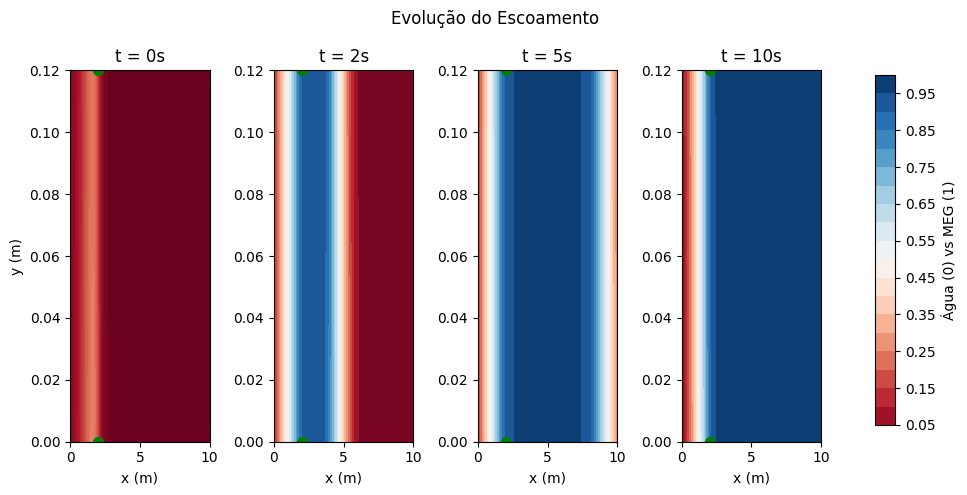

In [7]:
def plotagem(modelo, tempos=[0, 2, 5, 10]):
  fig, axs = plt.subplots(1, len(tempos), figsize=(10, 5), gridspec_kw={'width_ratios': [1]*len(tempos)})

  fig.subplots_adjust(right=0.85)
  cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
  vmin, vmax = 0, 1

  for i, t in enumerate(tempos):
    x = np.linspace(0, 10, 200)
    y = np.linspace(0, 0.12, 50)
    X, Y = np.meshgrid(x, y)

    xy_tensor = torch.FloatTensor(np.stack([X.flatten(), Y.flatten(), np.full_like(X.flatten(), t)], axis=1)).to(device)

    with torch.no_grad():
      _, _, _, C = modelo(xy_tensor[:, 0:1],xy_tensor[:, 1:2],xy_tensor[:, 2:3])

    cont = axs[i].contourf(X, Y, C.cpu().reshape(X.shape),levels=20, cmap='RdBu',vmin=vmin, vmax=vmax)
    axs[i].scatter([2, 2], [0, 0.12], c='green', s=50, marker='o')
    axs[i].set_title(f't = {t}s')
    axs[i].set_xlabel('x (m)')
    if i == 0:
      axs[i].set_ylabel('y (m)')


  fig.colorbar(cont,cax=cbar_ax,label='Água (0) vs MEG (1)')
  plt.suptitle("Evolução do Escoamento")
  plt.tight_layout(rect=[0, 0, 0.85, 1])
  plt.show()

plotagem(modelo_final)